In [1]:
import sys
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from venn import venn, pseudovenn

ROOT_PATH = '/home/karina/ehr_ood_detection/'
sys.path.append(ROOT_PATH)

from src.utils.scoreshandler import NoveltyScoresHandler

TABLES_DIR = os.path.join(ROOT_PATH, "data/novelty_tables")
DATA_ORIGIN = "VUmc"
RESULT_DIR = os.path.join(ROOT_PATH, "data/results")

### Load Novelty Score Handler

In [2]:
nsh = NoveltyScoresHandler(data_origin = "VUmc",
                          result_dir = RESULT_DIR)

In [3]:
IDs = nsh.get_top_outliers(N=50, multiindex=True)
IDs.head()

DUE                        VAE                \
             (entropy)  (std) (latent prior prob) (latent prob)   
Top Outliers                                                      
0                 9278  10988               15108         15824   
1                 9940   9278                5869          1961   
2                14773  14773               12823          7411   
3                11084  16166               12261          9278   
4                 2440   1806               15572          4322   

                                                NNEnsemble  \
             (reconstr err) (reconstr err grad)  (entropy)   
Top Outliers                                                 
0                     15824               16499      10988   
1                     14196                4992      15108   
2                     15108                5305       1051   
3                     12823               13170      16967   
4                      9278                9008      13522   

                                         AnchoredNNEnsemble  ...    LogReg  \
             (mutual information)  (std)          (entropy)  ... (entropy)   
Top Outliers                                                 ...             
0                           10988  10988              10988  ...      9062   
1                           15108  15108              15108  ...      9008   
2                           10686  10686              10686  ...     17839   
3                            5869   9278              10848  ...      5048   
4                            9278  16967              16812  ...     10997   

                               NN                        LOF       PPCA  \
             (max prob) (entropy) (max prob) (outlier score) (log prob)   
Top Outliers                                                              
0                  9062     10988      10988           15108      12823   
1                  9008     10686      10686           10848       9278   
2                 17839     16967      16967           12225       3303   
3                  5048     11669      11669           10234      13271   
4                 10997     13522      13522            9278      13463   

             MCDropout                                         AE  
             (entropy) (mutual information)  (std) (reconstr err)  
Top Outliers                                                       
0                 7538                 7755   7538          12823  
1                 1051                10939   1051           3303  
2                17423                13170   9278          13271  
3                16967                 7282  16967          13463  
4                11669                17839  16562           9421  

[5 rows x 22 columns]

### Venn diagram functions

In [4]:
# Find patient IDs for each model (either in AT LEAST ONE metric or in ALL metrics) and plot pseudovenn diagram

def get_id_sets(df, 
                column_list,
                type = "union"):
    sets = dict()
    
    for col in column_list:
        setlist = [set(df[col][i]) for i in df[col].columns]
        if type == "union":
            ids = set.union(*setlist)
        else:
            ids = set.intersection(*setlist)
        
        sets[col] = ids
        
    return sets

    
def plot_venn(df, 
              column_list,
              title=None):
    
    sets = get_id_sets(df, column_list)
    if len(column_list) == 6:
        pseudovenn(sets, fontsize = 8)
        
    else:
        venn(sets, fontsize = 8)
    
    if title is None:
        title = "Intersection of outlier from all models"
        
    plt.title(title)
    plt.show()

In [5]:
# Get all possible sets of size 6 from the available models

from itertools import chain, combinations

def powerset(iterable):
    s = list(iterable)
    return chain.from_iterable(combinations(s, r) for r in range(len(s)+1))

### Plot all models

In [ ]:
# Plot intersection of Patient IDs with different metrics for each model
fig = plt.figure(figsize =(20,12))

i = 0 
for col in IDs.columns.levels[0]:
    sets = dict()
    
    if 1 < len(IDs[col].columns) < 7:
        
        for subcol in IDs[col].columns:
            sets[col + ' ' + subcol] = set(IDs[col][subcol])
            
        ax = fig.add_subplot(2,3, i+1)   
        venn(sets, ax = ax, fontsize=8)
        
        i += 1

In [ ]:
# Plot pseudovenn for all the possible combinations of size 6 
res = list(powerset(IDs.columns.levels[0]))
res = [r for r in res if len(r) == 6]

for col_list in res:
    plot_venn(IDs, col_list, pseudo=True)

In [ ]:
# Pick the best column (that gets the most intersected IDs)


col_list = ["AE", "MCDropout", "NN", "NNEnsemble", "PPCA", "VAE"]
intrs = get_id_sets(IDs, col_list)

# Create a setlist from each model's patient's IDs to find the patients in the center of the Venn diagram
setlist = [set(v) for k,v in intrs.items()]
u = set.intersection(*setlist)
print(f"Patient IDs at the intersection: {u}.")

### Separate models

In [ ]:
ens = ["NNEnsemble", "AnchoredNNEnsemble", "MCDropout"]
nn = ["NN", "LogReg"]
density = ["PPCA", "LOF"]

model_types = {"Density Estimators": density, 
               "Ensembles and MCDropout": ens,
               "NN and Discriminators": nn}

for name, types in model_types.items():
    plot_venn(IDs, types, pseudo = False, title = name)

### Separate metrics

In [ ]:
IDs_sel = IDs.iloc[:,IDs.columns.get_level_values(1)=='(max prob)']
IDs_sel

In [ ]:
sets = get_id_sets(IDs_entropy, ["NN", "LogReg"])
venn(sets, fontsize = 8)
plt.title("Max probability")

### Density estimators

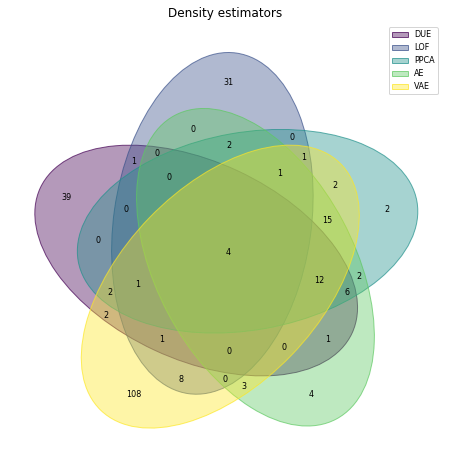

In [23]:
DENSITY_ESTIMATORS = ["DUE", "LOF", "PPCA", "AE", "VAE"]
plot_venn(IDs, DENSITY_ESTIMATORS, title = "Density estimators")